# Mount from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# clone from githup

In [ ]:
!git clone https://gitlab.com/bigirqu/quranqa

fatal: destination path 'quranqa' already exists and is not an empty directory.


# Important istallation

In [ ]:
pip install python-bidi

In [ ]:
!pip install arabic-reshaper

# Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from bidi.algorithm import get_display
from arabic_reshaper import reshape
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load data

In [ ]:
def read_data_from_json(path):
    # Define empty lists for the JSON objects and answers
    data = []
    answers_data = []
    # Open the JSON file and read it line-by-line
    with open(path, 'r') as f:
        # Use a generator expression to read the lines of the JSON file
        lines = (line.strip() for line in f)
        # Use json.JSONDecoder() to parse the JSON objects incrementally
        decoder = json.JSONDecoder()
        for line in lines:
            # Decode the JSON object and append it to the list
            obj, _ = decoder.raw_decode(line)
            data.append(obj)
            # Extract the ID from the JSON object and add it to each answer
            id = obj["pq_id"]
            for answer in obj["answers"]:
                answer["pq_id"] = id
                answers_data.append(answer)

    # Convert the list of answer dictionaries into a pandas DataFrame
    answer_df = pd.json_normalize(answers_data)

    # Convert the list of JSON objects into a pandas DataFrame
    all_data = pd.json_normalize(data)

    # Merge the two DataFrames on the 'pq_id' column
    merged_data = pd.merge(all_data, answer_df, on="pq_id")
    merged_data = merged_data.drop(columns=["answers"])
    merged_data = merged_data.rename(columns={"text":"answer"})
    # Return the merged DataFrame
    return merged_data

In [ ]:
train = read_data_from_json("/content/drive/MyDrive/Quran_QA/json_data/qrcd_v1.1_train.jsonl")
validation = read_data_from_json("/content/drive/MyDrive/Quran_QA/json_data/qrcd_v1.1_dev.jsonl")
test = read_data_from_json("/content/drive/MyDrive/Quran_QA/json_data/qrcd_v1.1_test_gold.jsonl")

In [ ]:
print(f"shape of train data is {train.shape}.")
print(f"shape of validation data is {validation.shape}.")
print(f"shape of test data is {test.shape}.")

shape of train data is (861, 7).
shape of validation data is (128, 7).
shape of test data is (300, 7).


In [ ]:
column_of_interest = ["pq_id","passage","question","answer","start_char"]

In [ ]:
train[column_of_interest].to_csv("/content/drive/MyDrive/Quran_QA/DataCsv/train.csv",index=False)
test[column_of_interest].to_csv("/content/drive/MyDrive/Quran_QA/DataCsv/test.csv",index=False)
validation[column_of_interest].to_csv("/content/drive/MyDrive/Quran_QA/DataCsv/validation.csv",index=False)

# Explore train data

### 1- explore columns and check null and duplicates

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 861 entries, 0 to 860
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pq_id       861 non-null    object
 1   passage     861 non-null    object
 2   surah       861 non-null    int64 
 3   verses      861 non-null    object
 4   question    861 non-null    object
 5   answer      861 non-null    object
 6   start_char  861 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 53.8+ KB


In [ ]:
# check if there are null values in all columns
train.isnull().sum().sum()

0

In [ ]:
train.describe()

,surah,start_char
count,861.000000,861.000000
mean,23.785134,182.296167
std,23.325933,170.288474
min,2.000000,0.000000
25%,5.000000,43.000000
50%,17.000000,144.000000
75%,35.000000,268.000000
max,109.000000,1353.000000


In [ ]:
# check duplicated
train.duplicated().sum()

0

###2- display examples of question and answeres

In [ ]:
def print_sample(idx):
  passage = train.iloc[idx]["passage"].split(".")
  passage = '\n'.join(passage)
  question = train.iloc[idx]["question"]
  answers = list(train[(train["question"] == question) & (train["passage"] == train.iloc[idx]["passage"])]["answer"].values)
  print(f"passage is : \n{passage}")
  print(f"question is : \n{question}")
  for i, answer in enumerate(answers):
    print(f"answer {i+1} is : \n {answer}")

In [ ]:
print_sample(3)

passage is : 
وجعلنا الليل والنهار آيتين فمحونا آية الليل وجعلنا آية النهار مبصرة لتبتغوا فضلا من ربكم ولتعلموا عدد السنين والحساب وكل شيء فصلناه تفصيلا
 وكل إنسان ألزمناه طائره في عنقه ونخرج له يوم القيامة كتابا يلقاه منشورا
 اقرأ كتابك كفى بنفسك اليوم عليك حسيبا
 من اهتدى فإنما يهتدي لنفسه ومن ضل فإنما يضل عليها ولا تزر وازرة وزر أخرى وما كنا معذبين حتى نبعث رسولا
 وإذا أردنا أن نهلك قرية أمرنا مترفيها ففسقوا فيها فحق عليها القول فدمرناها تدميرا
 وكم أهلكنا من القرون من بعد نوح وكفى بربك بذنوب عباده خبيرا بصيرا

question is : 
لماذا سيُحاسب ويُعذب الضال يوم القيامة ان كان ""من يضلل الله فما له من هاد"" كما ورد من قوله تعالى في آية 23 و آية 36 من سورة الزمر؟
answer 1 is : 
 كل إنسان ألزمناه طائره في عنقه
answer 2 is : 
 من اهتدى فإنما يهتدي لنفسه ومن ضل فإنما يضل عليها


### 3- explore qestion

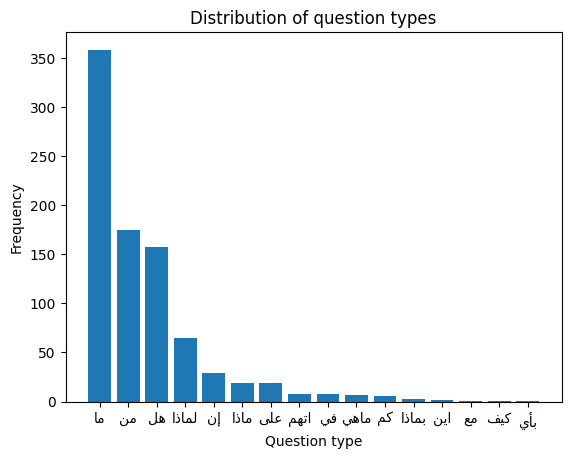

In [ ]:
# Compute the frequency of different question types
question_types = train['question'].apply(lambda x: x.split()[0])
question_type_counts = question_types.value_counts()

# Reshape the tick labels for right-to-left display
reshaped_labels = [get_display(reshape(label)) for label in question_type_counts.index]

# Plot the distribution of question types
fig, ax = plt.subplots()
ax.bar(reshaped_labels, question_type_counts.values)
ax.set_title('Distribution of question types')
ax.set_xlabel('Question type')
ax.set_ylabel('Frequency')
plt.show()

In [ ]:
# print random samples for question dosn't have question word
for question_type in ["إن","علي","في", "اتهم", "مع"]:
    for question in (
        train[train.question.str.startswith(question_type)]['question'].unique()):
        print(question)

إن كان الله قدّر علي أفعالي فلماذا يحاسبني؟
في كم يوم خلق الله الكون؟
اتهم القرآن بأنه السبب في الدكتاتورية الإسلامية لكونه أباح التكفير وقتال الكفار حتى يسلموا، كيف نرد على ذلك؟
مع أن السؤال هو أساس كل العلوم، لماذا نهى الله المؤمنين عن طرح الأسئلة كما جاء في سورة المائدة آية 101؟


In [ ]:
# Analyze the frequency of words in the questions
question_words = [w.lower() for _,q in train.iterrows() for w in q['question'].split()]
question_word_counts = Counter(question_words)
question_top_words = [word for word, count in question_word_counts.most_common(20)]
question_top_counts = [count for word, count in question_word_counts.most_common(20)]
print("Most common words in the questions:")
for word, count in question_word_counts.most_common(20):
    print(f"{word}: {count}")

Most common words in the questions:
ما: 359
في: 281
من: 266
هي: 258
التي: 192
هل: 158
القرآن؟: 147
هم: 122
القرآن: 103
الحيوانات: 100
انواع: 96
ذكرت: 96
هو: 85
الله: 77
على: 69
لماذا: 66
الإسلام: 63
الله؟: 61
تشير: 47
لا: 45


<ipython-input-61-070477d7c674>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(reshaped_labels)


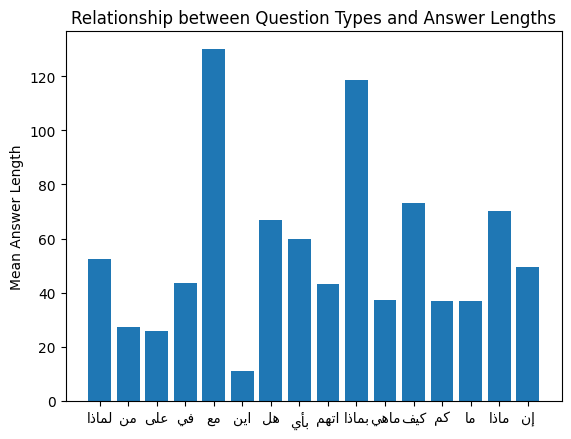

In [ ]:
# Calculate mean answer length for each question type
question_types = [q.split()[0].lower() for q in list(train["question"].unique())]
unique_question_types = list(set(question_types))
question_type_answer_lengths = {t: [] for t in unique_question_types}

for q in list(train["question"].unique()):
    t = q.split()[0].lower()
    for _,a in train[train["question"] == q].iterrows():
        question_type_answer_lengths[t].append(len(a["answer"]))
mean_lengths = [np.mean(question_type_answer_lengths[t]) for t in unique_question_types]

# Create bar chart with RTL tick labels
fig, ax = plt.subplots()
ax.bar(unique_question_types, mean_lengths)
ax.set_ylabel('Mean Answer Length')
ax.set_title('Relationship between Question Types and Answer Lengths')

# Reshape tick labels for RTL display using bidi.algorithm and arabic_reshaper
reshaped_labels = [get_display(reshape(label)) for label in unique_question_types]
ax.set_xticklabels(reshaped_labels)

plt.show()

### 4 -explore answers and passage

In [ ]:
passage_lengths = train['passage'].apply(lambda x : len(str(x).split()))

# Compute statistics on passage words count
mean_length = passage_lengths.mean()
median_length = passage_lengths.median()
std_dev = passage_lengths.std()

# Print the statistics
print(f"Mean passage word counts: {mean_length:.2f}")
print(f"Median passage word counts:: {median_length:.2f}")
print(f"Standard deviation of passage word counts:: {std_dev:.2f}")

Mean passage word counts: 80.64
Median passage word counts:: 74.00
Standard deviation of passage word counts:: 36.66


In [ ]:
qrcd_df = train.copy()
# Tokenize the passages and remove stop words
stop_words = stopwords.words('arabic')
qrcd_df['passage_tokens'] = qrcd_df['passage'].apply(lambda x: [w for w in word_tokenize(x) if w not in stop_words])

# Compute the frequency of different topics in the passages
topic_counts = {}
for tokens in qrcd_df['passage_tokens']:
    for token in tokens:
        if token in topic_counts:
            topic_counts[token] += 1
        else:
            topic_counts[token] = 1

# Sort the topics by frequency
sorted_topics = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 topics
for topic, count in sorted_topics[:10]:
    print(f"{topic}: {count}")

.: 5040
الله: 1955
قال: 513
آمنوا: 260
الأرض: 240
قالوا: 223
عليهم: 212
والله: 211
قوم: 182
شيء: 178


In [ ]:
# Calculate the max and min of answer words count
answer_lengths = train['answer'].apply(lambda x : len(str(x).split()))
print(f"Max answer length: {np.max(answer_lengths)}")
print(f"Min answer length: {np.min(answer_lengths)}")

Max answer length: 225
Min answer length: 1


In [ ]:
# Calculate the max and min of passage words count
answer_lengths = train['passage'].apply(lambda x : len(str(x).split()))
print(f"Max answer length: {np.max(answer_lengths)}")
print(f"Min answer length: {np.min(answer_lengths)}")

Max answer length: 302
Min answer length: 21


In [ ]:
# Analyze the relationship between passage lengths and answer lengths
passage_answer_lengths = []
for p in list(train["passage"].unique()):
    for _,a in train[train["passage"] == p].iterrows():
        passage_answer_lengths.append((len(p), len(a["answer"])))
passage_lengths, answer_lengths = zip(*passage_answer_lengths)
print(f"Correlation between passage length and answer length: {np.corrcoef(passage_lengths, answer_lengths)[0,1]:.2f}")

Correlation between passage length and answer length: 0.17


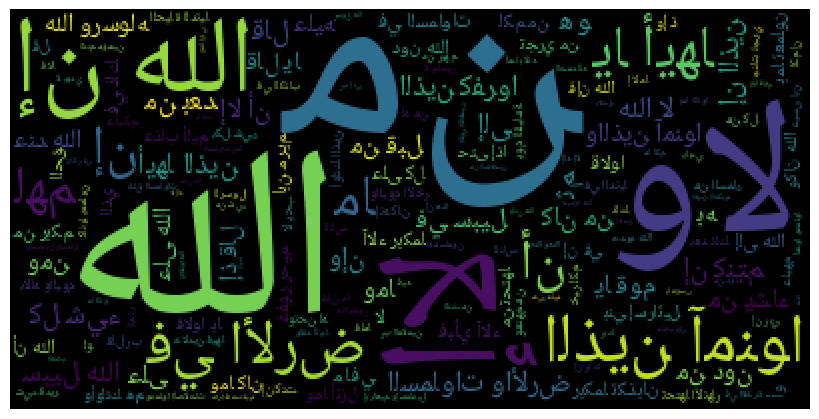

In [ ]:
# Combine all the text into a single string
all_text = ' '.join(train['passage'].tolist())
# Make text readable for a non-Arabic library like wordcloud
text = reshape(all_text)
text = get_display(text)

# Generate a word cloud image
wordcloud = WordCloud(font_path='/content/NotoNaskhArabic-Regular.ttf').generate(text)
# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

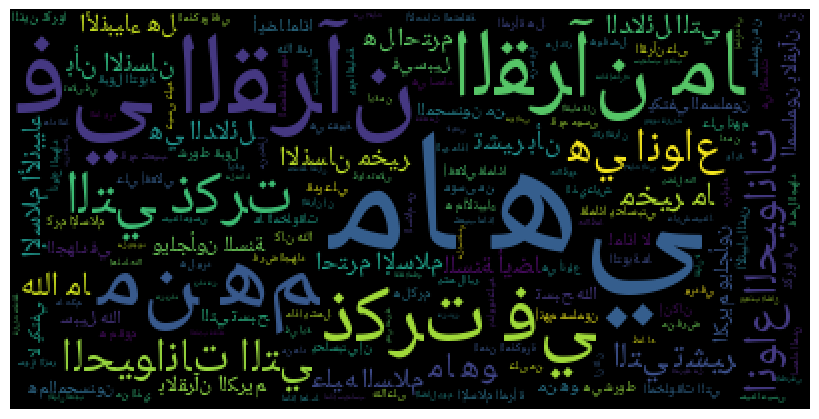

In [ ]:
# Combine all the text into a single string
all_text = ' '.join(train['question'].tolist())
# Make text readable for a non-Arabic library like wordcloud
text = reshape(all_text)
text = get_display(text)

# Generate a word cloud image
wordcloud = WordCloud(font_path='/content/NotoNaskhArabic-Regular.ttf').generate(text)
# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()